In [1]:
from fz_text_seg import tokenization, lexical_score, find_boundaries, get_depth_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
w_token = 20
k_block = 10

In [3]:
text_tokens, unique_tokens, paragraphs = tokenization('corpus.txt', w_token)
paragraphs

[2677, 5229]

In [4]:
lex_score, lex_score_smooth = lexical_score(text_tokens, unique_tokens, k_block)
depth_score = get_depth_score(lex_score_smooth)

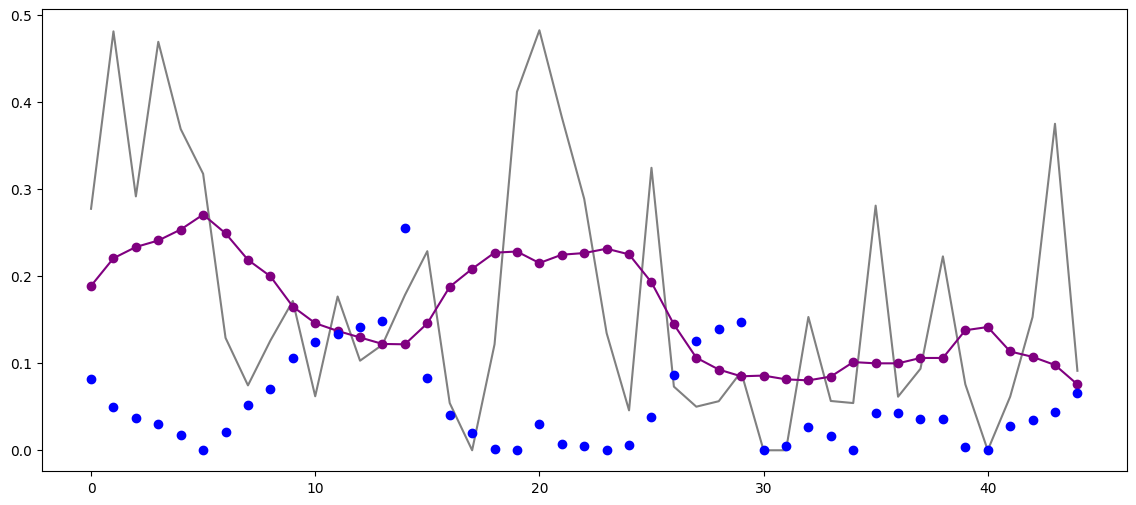

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(np.arange(0, len(lex_score)), lex_score, '-', color='grey')
ax.plot(np.arange(0, len(lex_score_smooth)), lex_score_smooth, '-o', color='purple')
ax.plot(np.arange(0, len(depth_score)), depth_score, 'o', color='blue')

In [6]:
find_boundaries(lex_score_smooth, 2)

[0.2555593101125627,
 0.1485529838068022,
 0.1474035974541248,
 0.14109942388180288,
 0.1387717577845962,
 0.13361274083991126,
 0.12521355521750976,
 0.12472385141741466,
 0.1056480281762785,
 0.08694436535871458,
 0.08255251085380555,
 0.08186754613508024,
 0.07085906626525332,
 0.06588977717160309,
 0.0519853640867359,
 0.05011217869358245,
 0.043618007012234394,
 0.04312520377096189,
 0.04312520377096189,
 0.04051605652137935,
 0.03870617429682796,
 0.0372022342062244,
 0.0355440626755634,
 0.0355440626755634,
 0.03425214889641745,
 0.0297486742812251,
 0.029707454388527704,
 0.02809757434745082,
 0.026501864404784303,
 0.021533273081801002,
 0.019907298090118097,
 0.017149858514250882,
 0.016637408461178574,
 0.006895724539022485,
 0.0065372506908135675,
 0.005006261743217583,
 0.004346709878701685,
 0.003705447846286375,
 0.001326674628109592,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]